In [ ]:
import os
import glob
import gc
import joblib
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
    r2_score
)
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from tqdm.notebook import tqdm

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel("ERROR")

# ------------------------------------------------------------
# 1. Environment Setup
# ------------------------------------------------------------
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/MyDrive/StockPrediction_2024_FINAL"
STOCK_DIR = os.path.join(PROJECT_PATH, "data_final", "stocks")
SENTIMENT_PATH = os.path.join(PROJECT_PATH, "data_final", "enhanced_daily_sentiment.csv")

MODEL_SAVE_DIR = os.path.join(PROJECT_PATH, "saved_models_v1_final")
PLOT_SAVE_DIR = os.path.join(PROJECT_PATH, "validation_plots_v1")
HISTORY_SAVE_DIR = os.path.join(PROJECT_PATH, "training_history_v1")
RESULTS_PATH = os.path.join(PROJECT_PATH, "v1_final_metrics.csv")

for directory in [MODEL_SAVE_DIR, PLOT_SAVE_DIR, HISTORY_SAVE_DIR]:
    os.makedirs(directory, exist_ok=True)

stock_files = glob.glob(os.path.join(STOCK_DIR, "*.csv"))

if os.path.exists(SENTIMENT_PATH):
    df_sentiment = pd.read_csv(SENTIMENT_PATH, parse_dates=['Date']).set_index('Date')
else:
    df_sentiment = pd.DataFrame()

# ------------------------------------------------------------
# 2. Enhanced Loss + Model
# ------------------------------------------------------------

def profit_focused_loss(y_true, y_pred):
    direction_true = tf.sign(y_true)
    direction_pred = tf.sign(y_pred)
    direction_error = tf.cast(tf.not_equal(direction_true, direction_pred), tf.float32)
    magnitude_error = tf.abs(y_true - y_pred)
    move_size = tf.abs(y_true)
    size_weight = tf.where(move_size > 0.01, 2.0, 1.0)
    loss = (direction_error * 5.0 + 1.0) * magnitude_error * size_weight
    return tf.reduce_mean(loss)

def build_enhanced_gru(input_shape, dropout_rate=0.25):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(GRU(
        64,
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )))
    model.add(Dropout(dropout_rate))
    model.add(GRU(
        32,
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='nadam', loss=profit_focused_loss)
    return model

# ------------------------------------------------------------
# 3. Utilities
# ------------------------------------------------------------

def calculate_dynamic_lookback(ticker, volatility):
    if volatility > 0.025:
        return 10
    if any(x in ticker for x in ['ETF', 'BEES']):
        return 20
    return 15

def create_sequences(X_scaled, y_series, lookback):
    X, y = [], []
    for i in range(lookback, len(X_scaled)):
        X.append(X_scaled[i-lookback:i])
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

def predict_with_transductive(model, X_train, y_train, X_test, n_neighbors=20):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X_train_flat)

    base_preds = model.predict(X_test, verbose=0).flatten()
    _, indices = knn.kneighbors(X_test_flat)

    enhanced_preds = []
    for i, neighbor_indices in enumerate(indices):
        pattern_bias = np.mean(y_train[neighbor_indices])
        enhanced_pred = 0.7 * base_preds[i] + 0.3 * pattern_bias
        enhanced_preds.append(enhanced_pred)

    return np.array(enhanced_preds)

# ------------------------------------------------------------
# Main Training Pipeline
# ------------------------------------------------------------

def run_pipeline():

    print(f"Assets detected: {len(stock_files)}")
    results_log = []
    N_ENSEMBLE = 3

    for file_path in tqdm(stock_files):

        ticker = os.path.basename(file_path).replace(".csv", "")

        try:
            df = pd.read_csv(file_path, index_col=0, parse_dates=True)

            if not df_sentiment.empty:
                df = df.join(df_sentiment, how='left')
                df.fillna({'Daily_Sentiment_Score': 0,
                           'News_Volume': 0}, inplace=True)

            df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
            df['Target_Log_Returns'] = df['Log_Returns'].shift(-1)
            df.dropna(inplace=True)

            features = [c for c in [
                'Close', 'Log_Returns', 'RSI', 'SMA_50',
                'USD_INR', 'Volatility_20D',
                'Daily_Sentiment_Score', 'News_Volume'
            ] if c in df.columns]

            if len(df) < 100:
                continue

            split_idx = int(len(df) * 0.85)
            train_set = df.iloc[:split_idx]
            test_set = df.iloc[split_idx:]

            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(train_set[features])
            X_test_scaled = scaler.transform(test_set[features])

            joblib.dump(scaler,
                        os.path.join(MODEL_SAVE_DIR, f"scaler_{ticker}.pkl"))

            volatility = df['Log_Returns'].std()
            lookback = calculate_dynamic_lookback(ticker, volatility)

            X_train, y_train = create_sequences(
                X_train_scaled,
                train_set['Target_Log_Returns'],
                lookback
            )

            X_test, y_test = create_sequences(
                X_test_scaled,
                test_set['Target_Log_Returns'],
                lookback
            )

            if len(X_train) == 0:
                continue

            preds = []

            for ensemble_index in range(N_ENSEMBLE):

                tf.keras.backend.clear_session()

                model = build_enhanced_gru(
                    (X_train.shape[1], X_train.shape[2])
                )

                early_stop = EarlyStopping(
                    monitor='val_loss',
                    patience=8,
                    restore_best_weights=True
                )

                history = model.fit(
                    X_train,
                    y_train,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop]
                )

                # Save training history
                history_df = pd.DataFrame(history.history)
                history_df.to_csv(
                    os.path.join(
                        HISTORY_SAVE_DIR,
                        f"{ticker}_training_history_{ensemble_index}.csv"
                    ),
                    index=False
                )

                pred = predict_with_transductive(
                    model, X_train, y_train, X_test
                )

                preds.append(pred)

                model.save(
                    os.path.join(MODEL_SAVE_DIR,
                                 f"model_{ticker}.keras")
                )

            avg_pred = np.mean(preds, axis=0)

            base_prices = test_set['Close'].iloc[lookback:].values
            min_len = min(len(base_prices), len(avg_pred))

            actual_prices = base_prices[:min_len] * np.exp(y_test[:min_len])
            pred_prices = base_prices[:min_len] * np.exp(avg_pred[:min_len])

            mape = mean_absolute_percentage_error(actual_prices, pred_prices) * 100
            rmse = math.sqrt(mean_squared_error(actual_prices, pred_prices))
            mae = mean_absolute_error(actual_prices, pred_prices)
            r2 = r2_score(actual_prices, pred_prices)

            results_log.append({
                'Ticker': ticker,
                'MAPE': mape,
                'RMSE': rmse,
                'MAE': mae,
                'R2_Score': r2
            })

            plt.figure(figsize=(10, 5))
            plt.plot(actual_prices[-80:], label='Actual Price')
            plt.plot(pred_prices[-80:], linestyle='--', label='Predicted Price')
            plt.title(f"{ticker} | MAPE: {mape:.2f}%")
            plt.xlabel("Last 80 Test Samples")
            plt.ylabel("Price")
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_SAVE_DIR, f"{ticker}_val.png"))
            plt.close()

            gc.collect()

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    if results_log:
        df_results = pd.DataFrame(results_log)
        df_results.to_csv(RESULTS_PATH, index=False)

        print("\n" + "=" * 60)
        print("PIPELINE COMPLETED")
        print("=" * 60)
        print(f"Assets Processed: {len(df_results)}")
        print(f"Average MAPE: {df_results['MAPE'].mean():.2f}%")
        print(f"Average RMSE: {df_results['RMSE'].mean():.4f}")
        print(f"Average MAE:  {df_results['MAE'].mean():.4f}")
        print(f"Average R2:   {df_results['R2_Score'].mean():.4f}")
        print("=" * 60)

if __name__ == "__main__":
    run_pipeline()

Mounted at /content/drive
Assets detected: 59


  0%|          | 0/59 [00:00<?, ?it/s]


PIPELINE COMPLETED
Assets Processed: 57
Average MAPE: 1.09%
Average RMSE: 21.4678
Average MAE:  15.9849
Average R2:   0.9216


Mounted at /content/drive
Metrics File Found: /content/drive/MyDrive/StockPrediction_2024_FINAL/v1_final_metrics.csv

Selected Stocks:
Best   : AXISNIFTY.NS
Median : SBILIFE.NS
Worst  : ADANIENT.NS

Analyzing: AXISNIFTY.NS


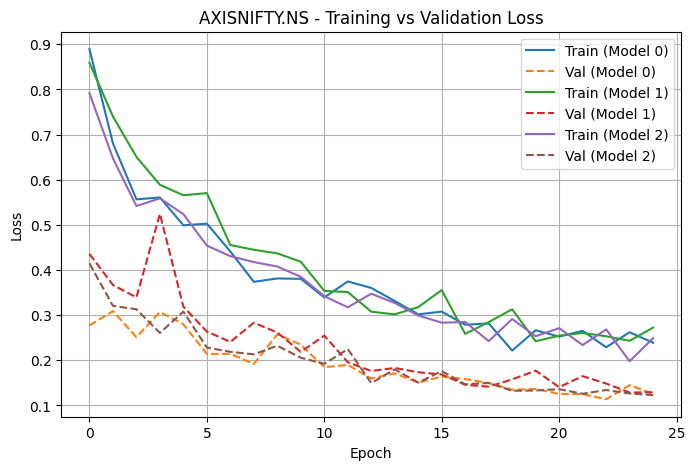


Analyzing: SBILIFE.NS


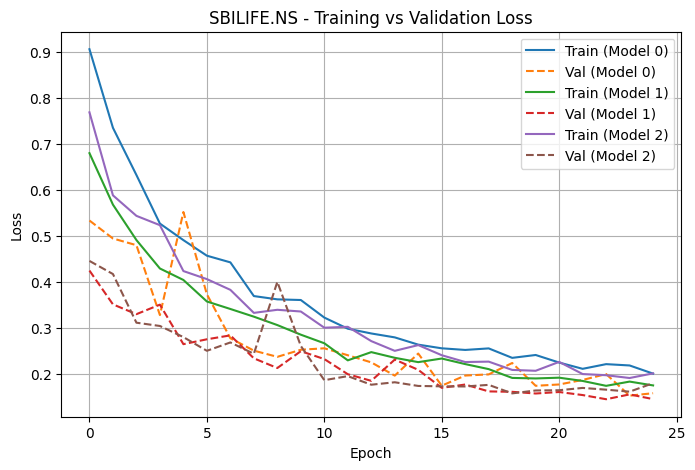


Analyzing: ADANIENT.NS


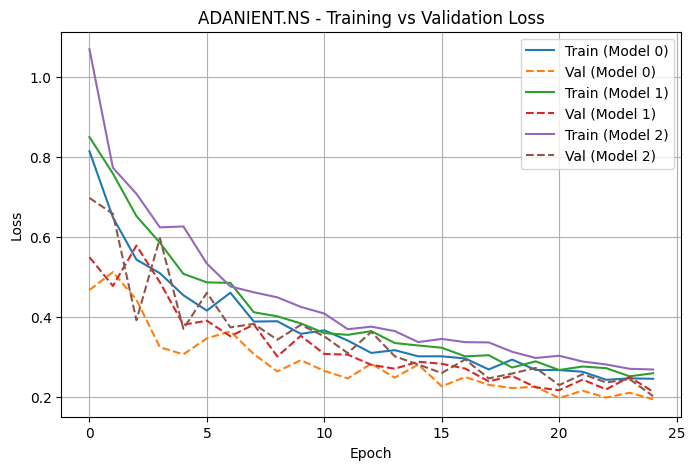

In [ ]:
# =============================================================
# LOSS vs VAL_LOSS ANALYSIS (BEST / MEDIAN / WORST STOCKS)
# =============================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# ------------------------------------------------------------
# 1. Mount Drive
# ------------------------------------------------------------
drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/MyDrive/StockPrediction_2024_FINAL"
HISTORY_DIR = os.path.join(PROJECT_PATH, "training_history_v1")

# ------------------------------------------------------------
# 2. Locate Metrics File Automatically
# ------------------------------------------------------------

metrics_file = None

for root, dirs, files in os.walk(PROJECT_PATH):
    for file in files:
        if "metrics" in file.lower():
            metrics_file = os.path.join(root, file)

if metrics_file is None:
    raise FileNotFoundError("Metrics CSV file not found in project directory.")

print("Metrics File Found:", metrics_file)

df_metrics = pd.read_csv(metrics_file)

# ------------------------------------------------------------
# 3. Select Best / Median / Worst by MAPE
# ------------------------------------------------------------

df_sorted = df_metrics.sort_values("MAPE").reset_index(drop=True)

best_stock = df_sorted.iloc[0]["Ticker"]
median_stock = df_sorted.iloc[len(df_sorted)//2]["Ticker"]
worst_stock = df_sorted.iloc[-1]["Ticker"]

selected_stocks = [best_stock, median_stock, worst_stock]

print("\nSelected Stocks:")
print("Best   :", best_stock)
print("Median :", median_stock)
print("Worst  :", worst_stock)

# ------------------------------------------------------------
# 4. Plot Loss vs Validation Loss
# ------------------------------------------------------------

for stock in selected_stocks:

    print(f"\nAnalyzing: {stock}")

    plt.figure(figsize=(8,5))
    found = False

    for i in range(3):  # ensemble = 3
        history_path = os.path.join(
            HISTORY_DIR,
            f"{stock}_training_history_{i}.csv"
        )

        if os.path.exists(history_path):

            found = True
            df_hist = pd.read_csv(history_path)

            if "loss" in df_hist.columns:
                plt.plot(df_hist["loss"], label=f"Train (Model {i})")

            if "val_loss" in df_hist.columns:
                plt.plot(df_hist["val_loss"], linestyle="--",
                         label=f"Val (Model {i})")

    if not found:
        print("No history files found.")
        continue

    plt.title(f"{stock} - Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()